In [43]:
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [44]:
# import the functions from local directory
sys.path.append("../helpers/functions")
from spike_preprocessing import spike_band_filtering
from spike_detection import detect_spikes, get_waveforms

In [45]:
# define constants
SAMPLE_RATE = 25000
DT = 1 / SAMPLE_RATE
FILE_PATH = "/Volumes/WD Passport/DataScienceProject/220113_S1_m.h5"
PRIMARY_COLOUR = "black"
T = 100000

In [46]:
# the data is stored in hdf5 format
def print_structure(name, obj):
    print(name)

with h5py.File(FILE_PATH, "r") as f:

    # view the hdf5 file structure
    f.visititems(print_structure)

    # get the channel data
    channel_data = f['Data/Recording_0/AnalogStream/Stream_0/ChannelData']

    print(f"\nChannel Data is type: {type(channel_data)} of size: {channel_data.size} and shape: {channel_data.shape}")
    
    # access the first second of data points from each channel
    first_second_of_data = channel_data[:, :SAMPLE_RATE]

    two_thousandth_second_of_data = channel_data[:, 2000 * SAMPLE_RATE:2001* SAMPLE_RATE]
    five_thousandth_second_of_data = channel_data[:, 4500 * SAMPLE_RATE:4501* SAMPLE_RATE]
    
    print(f"\n{len(first_second_of_data)} channels with {len(first_second_of_data[0])} values in each")

Data
Data/Recording_0
Data/Recording_0/AnalogStream
Data/Recording_0/AnalogStream/Stream_0
Data/Recording_0/AnalogStream/Stream_0/ChannelData
Data/Recording_0/AnalogStream/Stream_0/ChannelDataTimeStamps
Data/Recording_0/AnalogStream/Stream_0/InfoChannel

Channel Data is type: <class 'h5py._hl.dataset.Dataset'> of size: 7307400000 and shape: (60, 121790000)

60 channels with 25000 values in each


Let's access the first second of data and show how some of the channels simultaneously

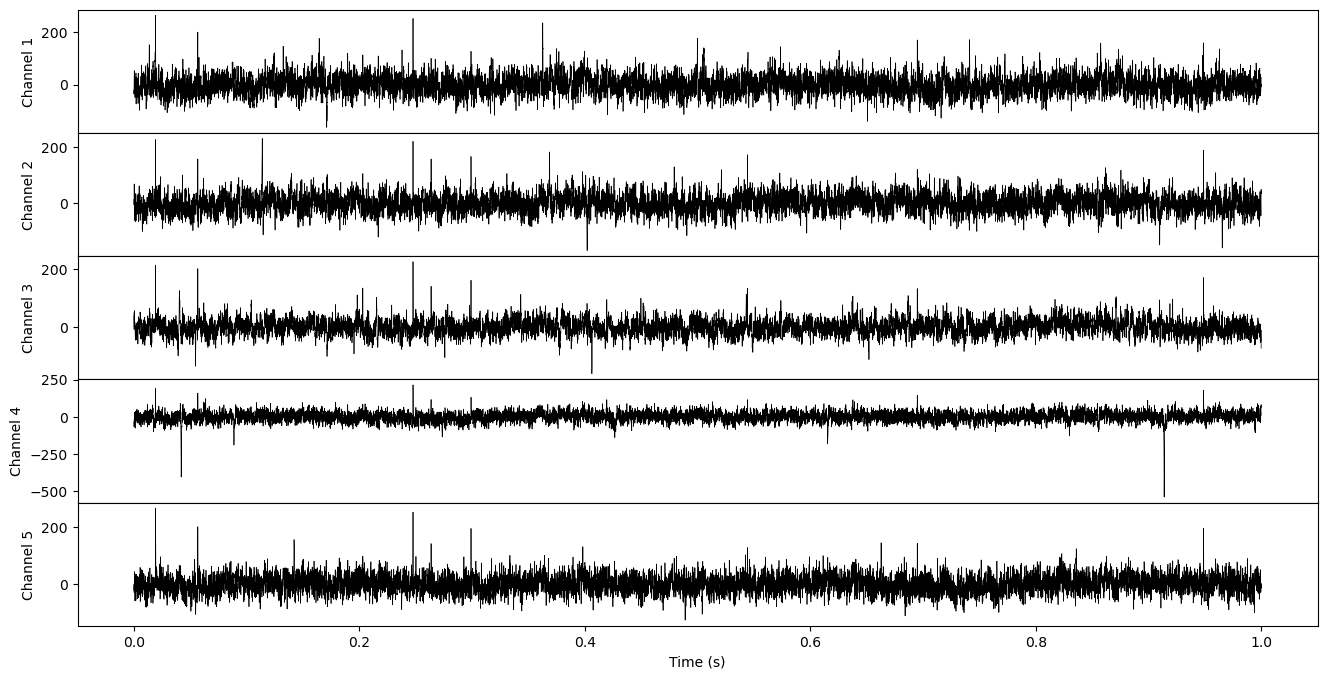

In [57]:
# so the time difference between each data point is 1/25000 seconds
time = np.arange(len(first_second_of_data[0])) / SAMPLE_RATE
five_channel_data = first_second_of_data[:5]

fig, axs = plt.subplots(5, 1, figsize=(16, 8), sharex=True)

for i in range(5):  
    data_points = five_channel_data[i, :] 
    axs[i].plot(time, data_points, c=PRIMARY_COLOUR, lw=0.5)
    axs[i].set_ylabel(f'Channel {i+1}') 

axs[-1].set_xlabel('Time (s)') 

plt.subplots_adjust(hspace=0) 
plt.show()

In [48]:
# # define the frequency band
# lowcut = 300.0
# highcut = 3000.0

# # define the Butterworth filter
# nyquist = 0.5 * SAMPLE_RATE
# low = lowcut / nyquist
# high = highcut / nyquist
# b, a = butter(1, [low, high], btype='band')

# # apply the filter to the data
# filtered_data = filtfilt(b, a, two_thousandth_second_of_data)

filtered_data = spike_band_filtering(y=two_thousandth_second_of_data, sample_rate=SAMPLE_RATE, low=500, high=4000)
filtered_data

array([[ 3.14194229e-02, -5.46314179e+00, -1.57549513e+01, ...,
        -1.66658349e+01, -1.59082220e+01, -4.37244174e+00],
       [-1.83362398e-01, -2.00344020e+01, -3.00846329e+01, ...,
        -2.92794831e+01, -2.10008612e+01, -1.18039584e+00],
       [ 6.90332958e-01, -4.82299534e+00, -5.32922790e+00, ...,
         1.69348400e+01,  7.80177779e+00, -6.20980546e-01],
       ...,
       [-3.40708670e-01, -1.92923215e+01, -3.13504064e+01, ...,
         4.29906500e+00, -1.53907573e+00, -5.06852802e-01],
       [ 3.07584687e-01, -1.55084049e+01, -3.15071958e+01, ...,
        -4.29996886e+01, -2.63645217e+01,  6.58774080e-01],
       [-1.90228682e-02, -2.97648324e+01, -4.97501728e+01, ...,
         3.17709499e+01,  2.12950285e+01,  2.22917360e+00]])

Compare the first channels signal before and after filtering

In [49]:
t = np.arange(0, T) * DT 
print(t)
print(len(t))

[0.00000e+00 4.00000e-05 8.00000e-05 ... 3.99988e+00 3.99992e+00
 3.99996e+00]
100000


In [50]:
filtered_data[49][0:T]
len(filtered_data[49][0:T])

25000

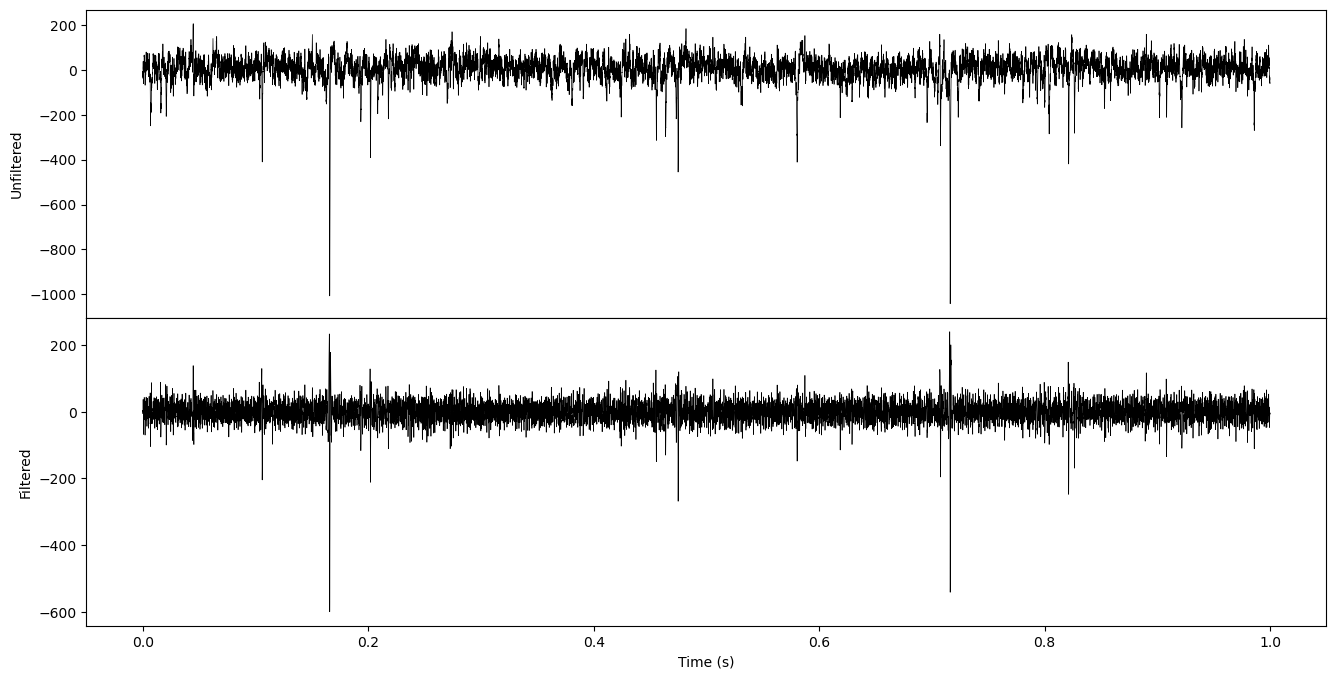

In [51]:
channel = 49

# so the time difference between each data point is 1/25000 seconds
time = np.arange(len(filtered_data[channel])) / SAMPLE_RATE

fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

axs[0].plot(time, two_thousandth_second_of_data[channel], c=PRIMARY_COLOUR, lw=0.5)
axs[0].set_ylabel(f'Unfiltered') 
axs[1].plot(time, filtered_data[channel], c=PRIMARY_COLOUR, lw=0.5)
axs[1].set_ylabel(f'Filtered') 

axs[-1].set_xlabel('Time (s)') 

plt.subplots_adjust(hspace=0) 
plt.show()

In [52]:
# calculate the threshold for each channel
threshold_multiplier = -3.5

mad = np.median(np.abs(filtered_data - np.median(filtered_data, axis=1, keepdims=True)) / 0.6745, axis=1)
thresholds = threshold_multiplier * mad

Text(0, 0.5, 'Voltage')

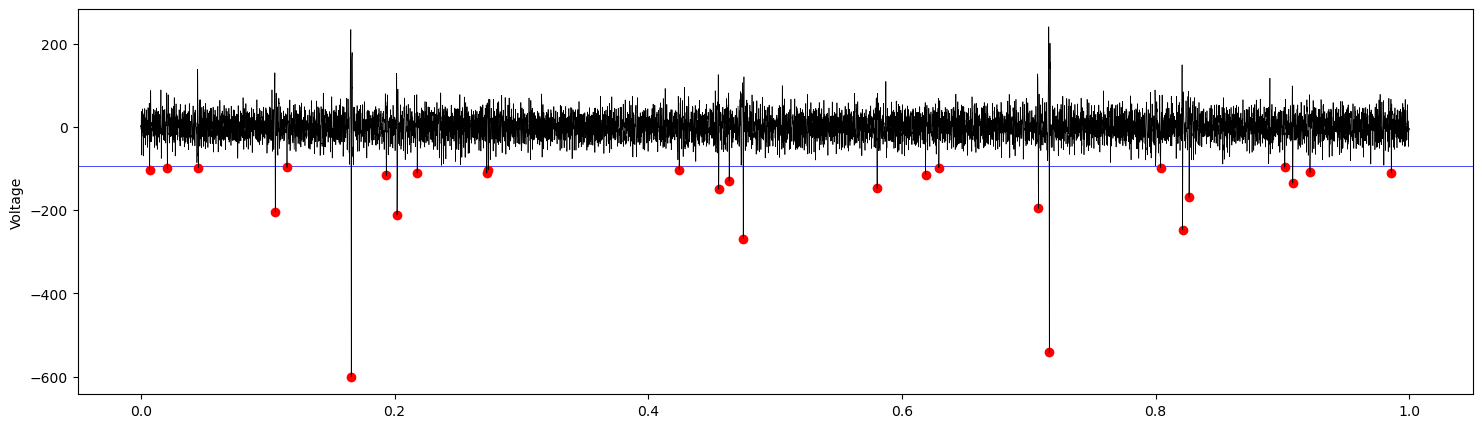

In [53]:
# channel to visualise
channel = 49

# get this channel's threshold value
threshold = thresholds[channel]

spikes = detect_spikes(filtered_data[channel], threshold=threshold, minimum_gap=1, use_absolute_threshold=True, flipped=True)

plt.figure(figsize=(18, 5))

plt.plot(time, filtered_data[channel], label='Raw Data', c=PRIMARY_COLOUR, lw=0.5)
plt.axhline(y=threshold, c="blue", linewidth=0.5, zorder=0)
plt.scatter(spikes * DT, filtered_data[channel][spikes], color='red')

plt.ylabel('Voltage')

In [54]:
waveforms, waveform_info = get_waveforms(y=filtered_data[channel], spike_indices=spikes, duration=1, sample_rate=SAMPLE_RATE, window_shift_ratio=1/3)

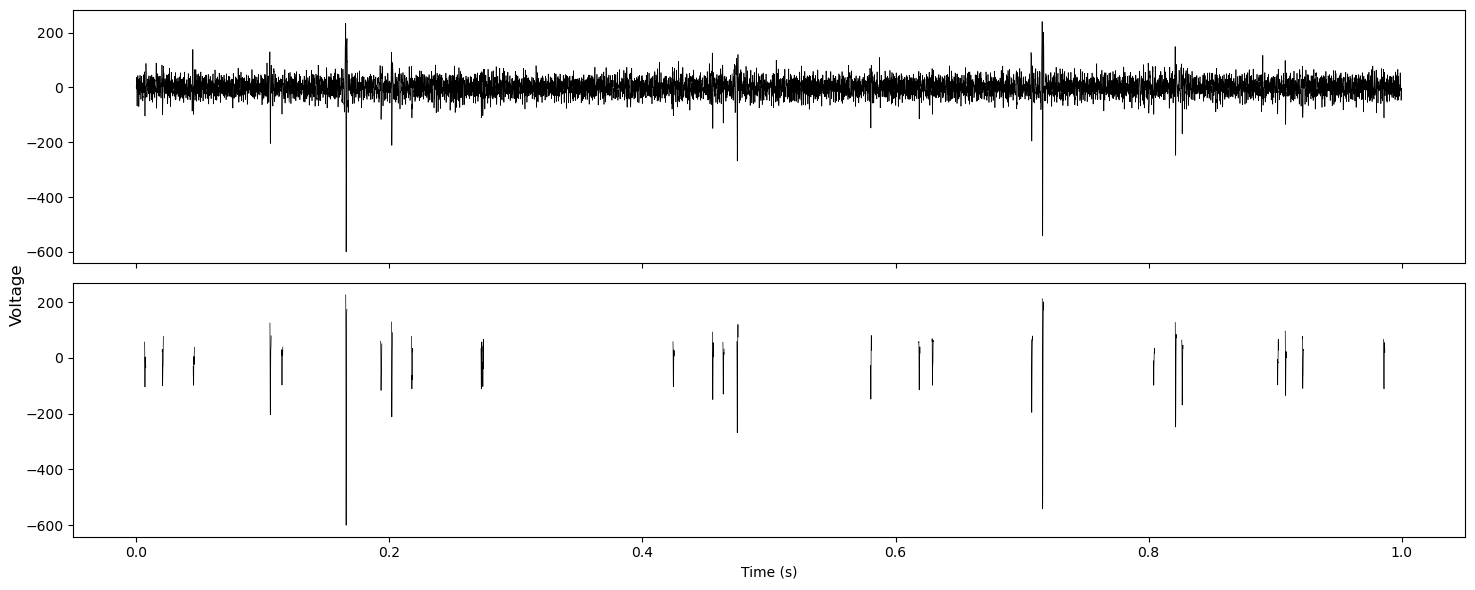

In [56]:
fig, axs = plt.subplots(2, 1, figsize=(15, 6), sharex=True)
time = np.arange(len(filtered_data[channel])) / SAMPLE_RATE

# plot the filtered data
axs[0].plot(time,  filtered_data[channel], label='Raw Data', c=PRIMARY_COLOUR, lw=0.5)

# iterate through each spike and plot its waveform
for spike in waveform_info:
    spike_window = slice(spike["spike_start"], spike["spike_end"])
    axs[1].plot(time[spike_window], filtered_data[channel][spike_window], c=PRIMARY_COLOUR, lw=0.5)

axs[1].set_xlabel('Time (s)')
fig.supylabel("Voltage")

plt.tight_layout()
plt.show()

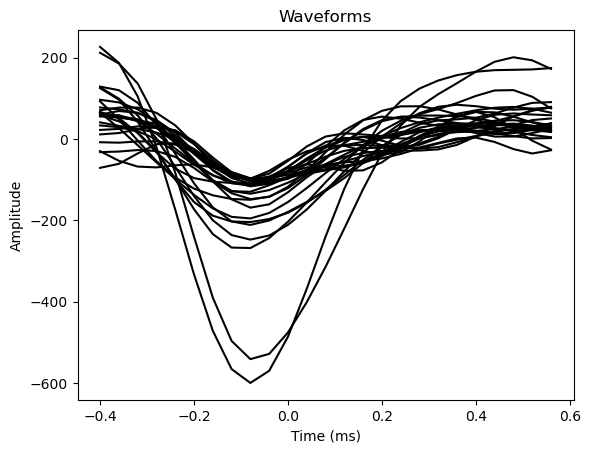

In [58]:
# iterate over the waveforms and plot each on top of each other
for i, waveform in enumerate(waveforms):
    t = np.arange(-10, 15) * DT * 1000 

    # plot the waveform
    plt.plot(t, waveform, c="black")

plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Waveforms')
plt.show()